In [26]:
import copy
import shap
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb

import sys
sys.path.append('../scripts/')
from utils import *
from config import *
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns

mlp.rcParams['lines.linewidth'] = 2
mlp.rcParams['axes.grid'] = True
mlp.rcParams['grid.linestyle'] = '--'
mlp.rcParams['xtick.labelsize'] = 12
mlp.rcParams['ytick.labelsize'] = 12
mlp.rcParams['axes.labelsize'] = 14
mlp.rcParams['legend.fontsize'] = 12
#mlp.rcParams['axes.xmargin'] = 0.01
mlp.rcParams['font.size'] = 12
mlp.rcParams['figure.figsize'] = (5,5)

mlp.rcParams['xtick.direction'] = 'in'
mlp.rcParams['xtick.major.size'] = 3
mlp.rcParams['xtick.major.width'] = 0.5
mlp.rcParams['xtick.minor.size'] = 1.5
mlp.rcParams['xtick.minor.width'] = 0.5
mlp.rcParams['xtick.minor.visible'] = True
mlp.rcParams['xtick.top'] = True

mlp.rcParams['ytick.direction'] = 'in'
mlp.rcParams['ytick.major.size'] = 3
mlp.rcParams['ytick.major.width'] = 0.5
mlp.rcParams['ytick.minor.size'] = 1.5
mlp.rcParams['ytick.minor.width'] = 0.5
mlp.rcParams['ytick.minor.visible'] = True
mlp.rcParams['ytick.right'] = True

mlp.rcParams['font.family'] = 'serif'
mlp.rcParams['mathtext.fontset'] = 'dejavuserif'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [2]:
with open('../data/comb.pickle', 'rb') as handle:
    data = pickle.load(handle)

df, metadata, features, target, rows = data.values()

In [3]:
features = ['BCUT2D_MRHI','AXp-6dv','piPC4','GATS1d','Kappa3','AATS7i','AATS8i','GATS2v','MATS1v','GATS2m','MATS2s','MATS2d','GATS3dv','GATS4dv',
            'ATSC5c','ATSC5d','GATS6s','ATSC7dv','MPC5','BCUTi-1h','fr_Ndealkylation1','MINssO','MDEC-13','PEOE_VSA8','MINdO','BCUTdv-1l','fr_NH0',
            'naHRing','SlogP_VSA10']

In [4]:
train = df.loc[rows,features+[target]].copy()
train.reset_index(drop=True, inplace=True)
train[target].replace({'Bitter': 0, 'Sweet': 1}, inplace=True)
custom_cv = create_folds(train=train, features=features, target=target, num_folds=NUM_FOLDS, shuffle=True, seed=SEED)

In [6]:
preds = evaluate(params=PARAMS_GB, train=train, features=features, target=target, folds=custom_cv, return_res=False, return_preds=True)

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[178]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.943664 + 0.00463704
Fold 1 AUC: 0.94383
Fold 2 AUC: 0.94880
Fold 3 AUC: 0.93609
Fold 4 AUC: 0.94805
Fold 5 AUC: 0.94154
Folds AUC: 0.94366+-0.00464
Total AUC: 0.94290


In [8]:
train_lgb = lgb.Dataset(train[features], train[target], feature_name=features, free_raw_data=False)
callbacks = [lgb.log_evaluation(period=1, show_stdv=True), lgb.early_stopping(stopping_rounds=PARAMS_GB['early_stopping_round'], first_metric_only=False, verbose=True)]
cv_results = lgb.cv(params=PARAMS_GB,
                    train_set=train_lgb,
                    folds=custom_cv,
                    metrics=PARAMS_GB['metric'],
                    num_boost_round=PARAMS_GB['num_iterations'],
                    stratified=False,
                    callbacks=callbacks,
                    eval_train_metric=True,
                    return_cvbooster=True)
best_iteration = cv_results['cvbooster'].best_iteration

[1]	cv_agg's train auc: 0.929468 + 0.00350712	cv_agg's valid auc: 0.872306 + 0.00607341
Training until validation scores don't improve for 20 rounds
[2]	cv_agg's train auc: 0.941803 + 0.00324822	cv_agg's valid auc: 0.883913 + 0.0108095
[3]	cv_agg's train auc: 0.951804 + 0.00332069	cv_agg's valid auc: 0.895683 + 0.0105314
[4]	cv_agg's train auc: 0.957631 + 0.00198816	cv_agg's valid auc: 0.903458 + 0.00671765
[5]	cv_agg's train auc: 0.961193 + 0.00124475	cv_agg's valid auc: 0.904798 + 0.00748386
[6]	cv_agg's train auc: 0.965907 + 0.000820831	cv_agg's valid auc: 0.91012 + 0.00644459
[7]	cv_agg's train auc: 0.969774 + 0.00102196	cv_agg's valid auc: 0.914429 + 0.00613546
[8]	cv_agg's train auc: 0.972249 + 0.0015473	cv_agg's valid auc: 0.917704 + 0.00660216
[9]	cv_agg's train auc: 0.973834 + 0.00165465	cv_agg's valid auc: 0.919025 + 0.00648672
[10]	cv_agg's train auc: 0.975654 + 0.00123591	cv_agg's valid auc: 0.921088 + 0.0064731
[11]	cv_agg's train auc: 0.977572 + 0.00113217	cv_agg's valid 

In [9]:
PARAMS_GB_ = {i:PARAMS_GB[i] for i in PARAMS_GB if i not in ['early_stopping_round', 'num_iterations']}

In [10]:
model = lgb.train(params=PARAMS_GB_, train_set=train_lgb, num_boost_round=best_iteration)

In [39]:
# background = shap.maskers.Independent(train[features], max_samples=len(train))
# explainer = shap.Explainer(model.predict, background)
# shap_values = explainer(train[features])

# d = {'shap_values': shap_values}
# with open('../data/shap_values.pickle', 'wb') as handle:
#     pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
with open('../data/shap_values.pickle', 'rb') as handle:
    data = pickle.load(handle)

shap_values = data['shap_values']

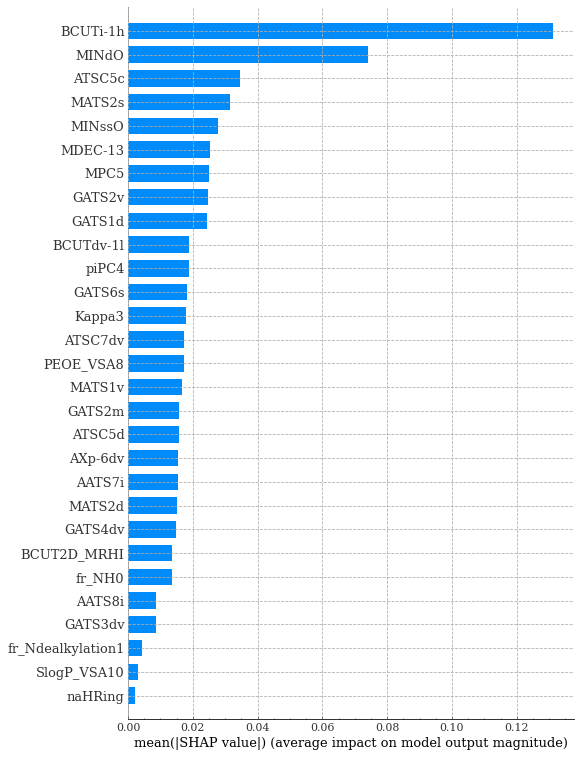

In [15]:
shap.summary_plot(shap_values, max_display=29, plot_type='bar')

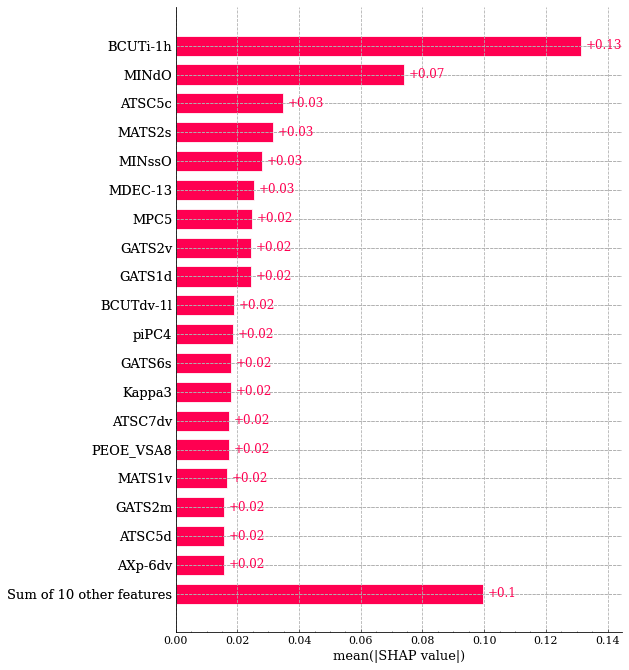

In [16]:
shap.plots.bar(shap_values, max_display=20)

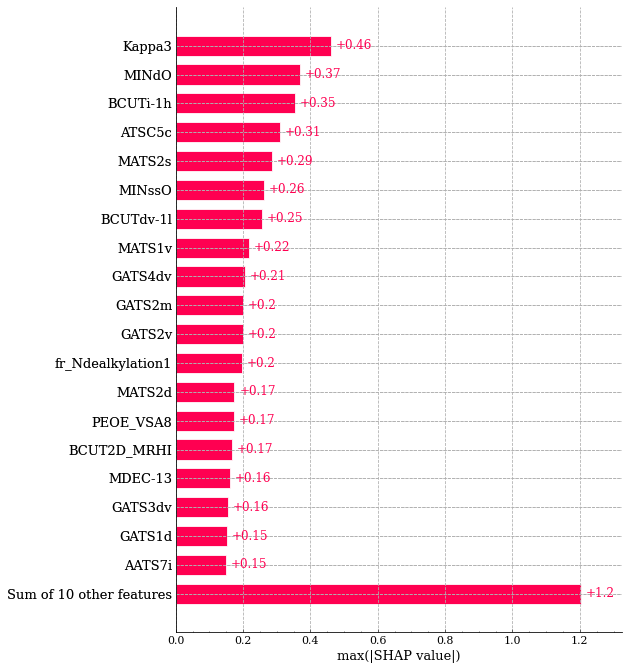

In [17]:
shap.plots.bar(shap_values.abs.max(0), max_display=20)

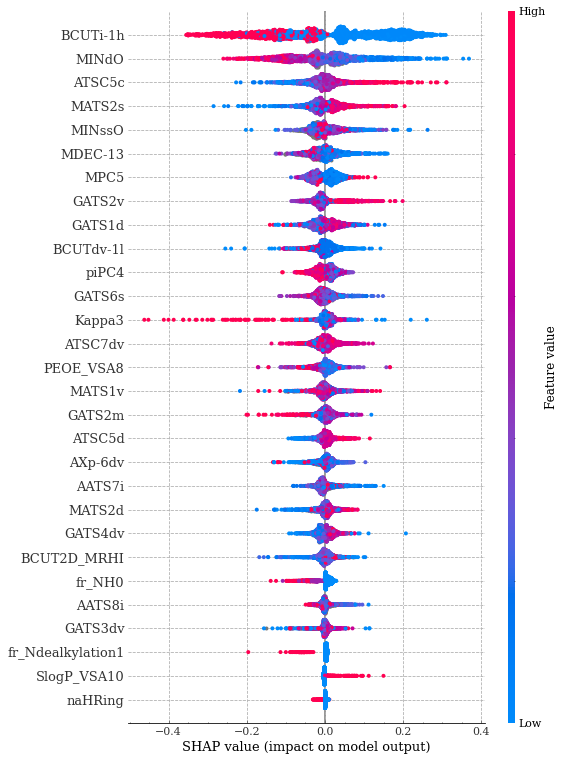

In [18]:
shap.plots.beeswarm(shap_values, max_display=30, show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

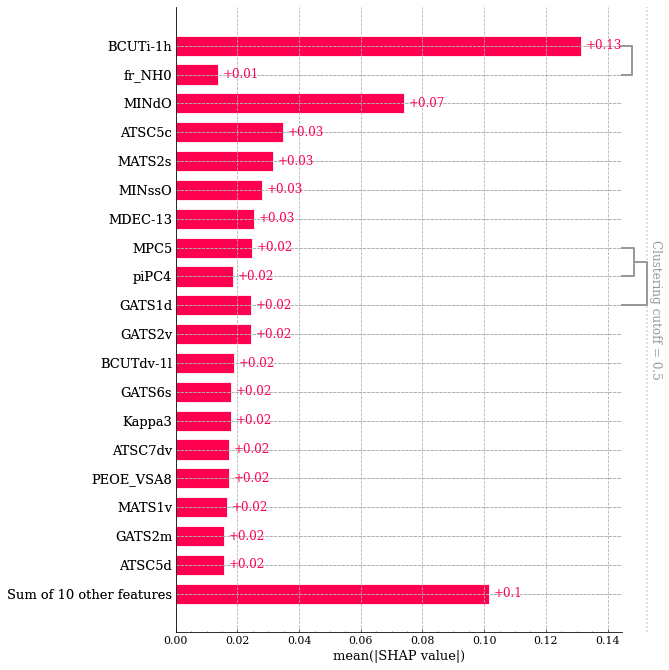

In [22]:
clustering = shap.utils.hclust(train[features], train[target])
shap.plots.bar(shap_values, clustering=clustering, max_display=20)

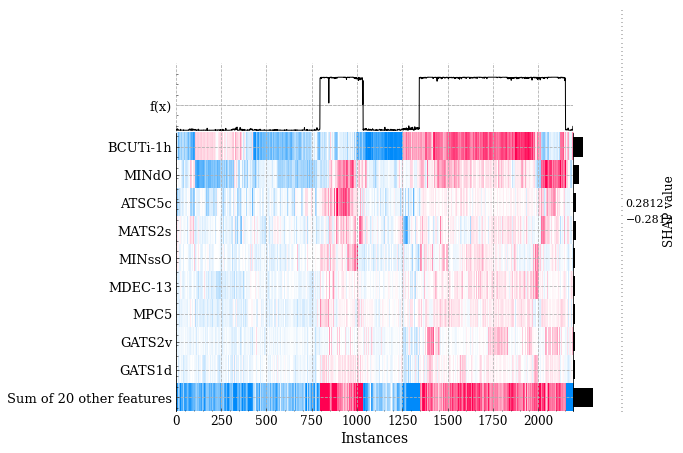

In [23]:
shap.plots.heatmap(shap_values)

<AxesSubplot:xlabel='Count', ylabel='shap'>

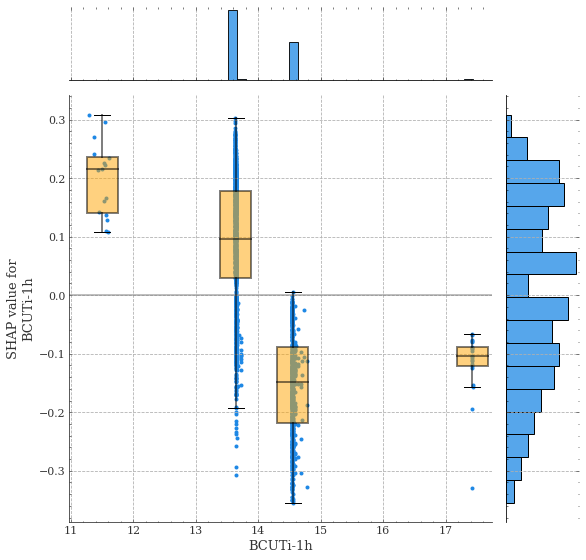

In [27]:
feature = 'BCUTi-1h'
x1 = 'data'
x2 = 'shap'
CLIP_LOWER = None
CLIP_UPPER = None
DROPNA = True
ORDER = 2
CI = 95
X_LIMS = None#(0.5,1.7)

df = pd.DataFrame({'shap': shap_values[:, feature].values, 'data': shap_values[:, feature].data})
if CLIP_LOWER and CLIP_UPPER:
    df.data = df.data.clip(lower=df.data.quantile(CLIP_LOWER), upper=df.data.quantile(CLIP_UPPER))
if DROPNA:
    full_mask = df.data.notnull() == True
    full_indices = df[full_mask].index.to_list()
else:
    full_indices = df.index.to_list()

shap_values_tmp = copy.deepcopy(shap_values)
shap_values_tmp.data[:, shap_values.feature_names.index(feature)] = df.data.values

bins = find_bins(df.data, 1)
df['bins'] = pd.cut(df.data, bins=bins)
df_grouped = df.groupby('bins', as_index=False)['data'].mean()
df = pd.merge(df, df_grouped, how='left', on='bins', suffixes=(None, '_binned'))
positions = df.data_binned.sort_values().unique().tolist()
data = [df[df.data_binned==p].shap.values for p in positions]
x,y = 'bins', 'shap'
g = sns.JointGrid(x=x, y=y, data=df, height=8)
shap.plots.scatter(shap_values_tmp[full_indices, feature], ax=g.ax_joint, hist=False, show=False)
g.ax_joint.axhline(0, c='grey', linewidth=2, linestyle='-', alpha=0.5)
boxprops = dict(linestyle='-', linewidth=2, color='black', alpha=0.5)
medianprops = dict(linestyle='-', linewidth=2, color='black', alpha=0.5)
whiskerprops = dict(linestyle='-', linewidth=2, color='black', alpha=0.5)
box=g.ax_joint.boxplot(data, widths=0.5, positions=positions, showmeans=False, manage_ticks=False, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, showfliers=False, patch_artist=True);
colors = ['orange']*len(data)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.5)
sns.histplot(x='data', data=df, color='#1E88E5', legend=False, ax=g.ax_marg_x)
sns.histplot(y='shap', data=df, color='#1E88E5', legend=False, ax=g.ax_marg_y)

In [24]:
def plot_shap_dependence_plot(shap_values, feature, dropna=False, clip_lower=None, clip_upper=None, drop_lower=None, drop_upper=None, order=2, ci=95, x_lim=None, y_lim=None, fig_height=8, var_type='continuos'):
    x1 = 'data'
    x2 = 'shap'
    
    df = pd.DataFrame({'shap': shap_values[:, feature].values, 'data': shap_values[:, feature].data})
    
    if clip_lower and clip_upper:
        df.data = df.data.clip(lower=df.data.quantile(clip_lower), upper=df.data.quantile(clip_upper))
        shap_values = copy.deepcopy(shap_values)
        shap_values.data[:, shap_values.feature_names.index(feature)] = df.data.values
    if dropna:
        full_mask = df.data.notnull() == True
        full_indices = df[full_mask].index.to_list()
    else:
        full_indices = df.index.to_list()

    if drop_lower and drop_upper:
        range_mask = (df.data > drop_lower) & (df.data < drop_upper)
        range_indices = df[range_mask].index.to_list()
    else:
        range_indices = df.index.to_list()
    
    indices = list(set(full_indices).intersection(set(range_indices)))
        
    g = sns.JointGrid(x=x1, y=x2, data=df, height=fig_height)
    sns.regplot(df.loc[indices].data, df.loc[indices].shap, ci=ci, ax=g.ax_joint, order=order, scatter=False, color='orange')
    sns.histplot(x=x1, data=df.loc[indices], color='#1E88E5', legend=False, ax=g.ax_marg_x)
    sns.histplot(y=x2, data=df.loc[indices], color='#1E88E5', legend=False, ax=g.ax_marg_y)
    
    if x_lim:
        g.ax_joint.set_xlim(x_lim)
    if y_lim:
        g.ax_joint.set_ylim(y_lim)
        
    shap.plots.scatter(shap_values[indices, feature], ax=g.ax_joint, hist=False, show=False, alpha=0.8)
    g.ax_joint.axhline(0, c='grey', linewidth=2, linestyle='-', alpha=0.5, zorder=5)
    roots = np.roots(np.polyfit(df.loc[indices].dropna(subset=['data']).data.values, df.loc[indices].dropna(subset=['data']).shap.values, deg=order))
    root = roots[(roots > g.ax_joint.get_xlim()[0]) & (roots < g.ax_joint.get_xlim()[1])][0]
    g.ax_joint.scatter(root, 0, s=50, marker='d', c='r', zorder=10)
    g.ax_joint.annotate(str(round(root,2)), (root, 0), fontsize=14)
    
    axis_color="k"
    g.ax_joint.set_xlabel(feature, color=axis_color, fontsize=14)
    g.ax_joint.set_ylabel(f'SHAP value for {feature}', color=axis_color, fontsize=14)
    g.ax_joint.xaxis.set_ticks_position('bottom')
    g.ax_joint.yaxis.set_ticks_position('left')
    g.ax_joint.spines['right'].set_visible(False)
    g.ax_joint.spines['top'].set_visible(False)
    g.ax_joint.tick_params(color=axis_color, labelcolor=axis_color, labelsize=14)

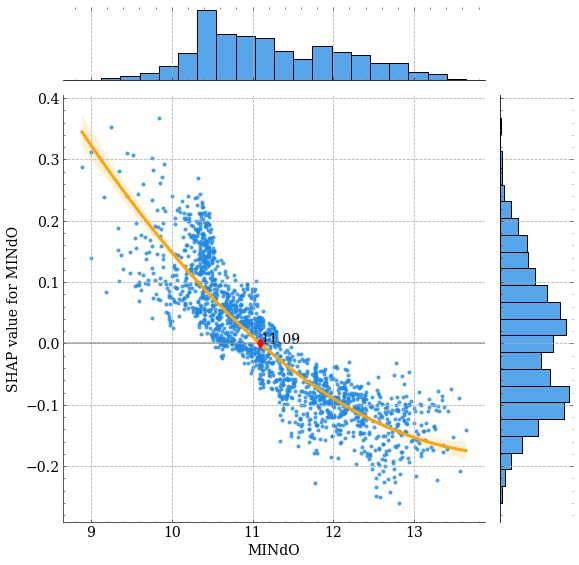

In [37]:
plot_shap_dependence_plot(shap_values, 'MINdO', dropna=True, drop_lower=8.7, drop_upper=13.7)

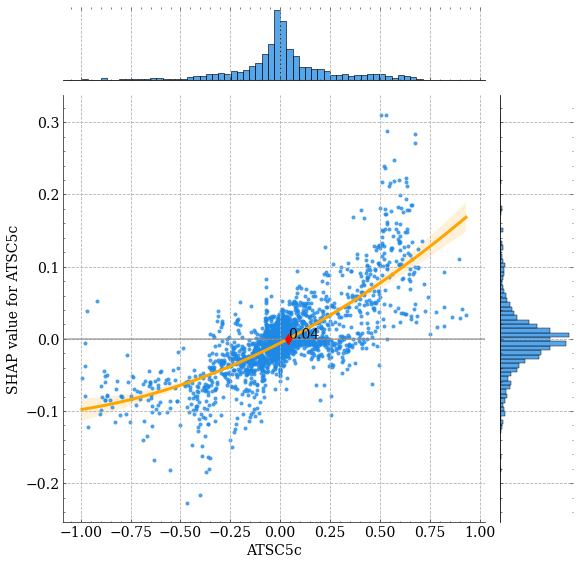

In [20]:
plot_shap_dependence_plot(shap_values, 'ATSC5c', drop_lower=-1, drop_upper=1)

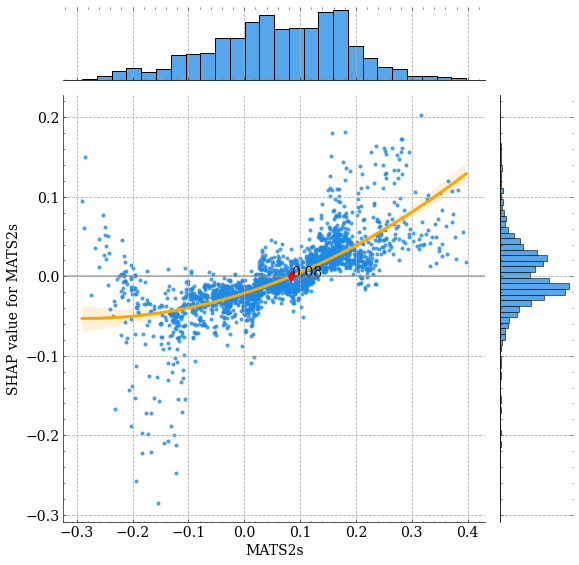

In [38]:
plot_shap_dependence_plot(shap_values, 'MATS2s', drop_lower=-0.3, drop_upper=0.4)